<h1 style='color:orange; font-weight:bold; text-align:center'>Latent Dirichlet Allocation</h1>

In [39]:
import re
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
from collections import Counter
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import warnings
import joblib
from sklearn.metrics.pairwise import cosine_similarity

plt.style.use('ggplot')
pd.options.display.max_colwidth=50
warnings.filterwarnings("ignore", category=DeprecationWarning)

## **4 Topic Modeling**
Previously, I already performed text analysis on the user reviews with raw frequencies approach. Using this approach, most frequent words or word combinations could be identified to investigate the rooms for improvement and the strengths of the app. While its usefulness to reveal the insights, it is important to note that this approach does not take relationship between words into account. This approach consideers words or word combinations in isolation. This approach, therefore, cannot capture key themes since themes or topics are identified based on co-texts or the relationship between words. Topic modeling, however, considers words in their co-texts, revealing insights into the main themes. Topics here identified by a distribution of words frequenty co-occur.

The metrics used in this project are perplexity (Bleei, Ng, & Jordan, [2002](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)) and coherence scores (Lau, Newman, & Baldwin, [2014](https://doi.org/10.3115/v1/E14-1056)). In short, perplexity aims to measure how the model fits the data. A lower perplexity score indicates better performance at predicting the distribution of topics. The drawback of this metric is that it does not always correlate with human interpretability. A small perplexity score, therefore, does not alway produce topics that make intutive sense. To address the interpretability issue, coherence score is also used. It measures semantic interpretability of topics generated by a model. Unlike perplexity, the interpretation of coherence score is the larger the score, the more interpretable the topics are. The coherence score is between 0 and 1.

### **4.1 Data Preparation**

In [40]:
# load the dataset
df4 = pd.read_csv('../data/review_gopay_newest_sort.csv')

In [41]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123253 entries, 0 to 123252
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   userName              123253 non-null  object
 1   content               123253 non-null  object
 2   score                 123253 non-null  int64 
 3   thumbsUpCount         123253 non-null  int64 
 4   reviewCreatedVersion  107325 non-null  object
 5   at                    123253 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.6+ MB


In [42]:
# convert at to datetime
df4['at'] = pd.to_datetime(df4['at'])

In [43]:
# prepare stopwords
# nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))
custom_stopwords = {'yang', 'aja', 'yg', 'nya', 'sih', 'oh', 'e', 'deh', 'ya', 'nih'}
stop_words.update(custom_stopwords)

# preprocess function
def tokenize_text(text):
    if isinstance(text, str):                                           # check if the input is a string
        text = text.lower()                                             # convert to lowercase
        text = re.sub(r'\d+', '__num__', text)                          # remove numbers
        text = re.sub(r'\W+', ' ', text)                                # remove punctuation
        text = re.sub(r'http\S+|www\S+', '__url__', text)               # remove URLs
        tokens = text.split()                                           # split into tokens
        tokens = [word for word in tokens if word not in stop_words]    # remove stopwords
        return tokens
    return []                                                           # if not string, return an empty list

# apply preprocessing
df4['tokens'] = df4['content'].apply(tokenize_text)

```python
!pip install sastrawi
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
from nltk.corpus import stopwords

# init Indonesian and English lemmatizers
factory = StemmerFactory()
indonesian_lemmatizer = factory.create_stemmer()
english_lemmatizer = WordNetLemmatizer()

# prepare stopwords
stop_words = set(stopwords.words('indonesian'))
custom_stopwords = {'yang', 'aja', 'yg', 'nya', 'sih', 'oh', 'e', 'deh'}
stop_words.update(custom_stopwords)

# preprocess function with lemmatization
def preprocess_text(text):
    if isinstance(text, str):                                           # check if the input is a string
        text = text.lower()                                             # convert to lowercase
        text = re.sub(r'\d+', '__num__', text)                          # replace numbers
        text = re.sub(r'\W+', ' ', text)                                # remove punctuation
        text = re.sub(r'http\S+|www\S+', '__url__', text)               # replace URLs
        tokens = text.split()                                           # split into tokens
        tokens = [word for word in tokens if word not in stop_words]    # remove stopwords
        
        # Lemmatize tokens
        lemmatized_tokens = []
        for word in tokens:
            if word.isalpha():
                # lemmatizing with Indonesian lemmatizer first, fallback to English
                lemma = indonesian_lemmatizer.stem(word)
                if lemma == word:  
                    # if not changed by Indonesian lemmatizer, apply English lemmatizer
                    lemma = english_lemmatizer.lemmatize(word)
                lemmatized_tokens.append(lemma)
            else:
                # keep non-alphabetic tokens as is
                lemmatized_tokens.append(word)  
        
        return lemmatized_tokens
    # return empty list for non-string values
    return []  

# Apply preprocessing
df4['tokens'] = df4['content'].apply(preprocess_text)

```

### **4.1 Brief Introduction to LDA**
Latent Dirichlet Allocation (LDA) is a topic modeling algorithm which is used to find topics in a collection of documents (or reviews in this context). This algorithm assumes every review is a combination of varying topics (e.g., 70% about usability, 20% about payment, and 10% about login), and each topic is a group of words that frequently appear together. For example, *usability* include "app", "navigate", "easy". To illustrate how LDA works, let us take a look at the general procedures.
- Suppose ther are three reviews: ["The app is easy to use.", "Payment processing takes too long", "Great app! The payment is fast and easy"]. Here LDA will uncover topics by looking at the word distributions across reviews. Second, LDA will assign each word in all reviews to one of topics (depending on how many number of topics were defined). For instance, [app (Topic 1), easy (topic 2), use (topic 2)].
- LDA will iterate the process where it reassigns words to topics based on how often the words appears in each topic across all reviews and how much of a document is dedicated to each topic. For example, *app* might appear more frequently in Topic 1 as it is common across reviews discussing about usability. Third, after multiple iterations and topic adjustment, LDA will converge on stable assignment. 

### **4.2 Grid Search of Ideal Topic Number**

Similar to *k*-mean clustering, topic modeling using Latent Dirichlet Allocation also needs one of the parameter to be specified. One way to determine the optimal number of topics is with perplexity score or coherence score. Perplexity focuses more on the topic model's statistical performance and prediction ability whereas coherence score is concerned more with the human interpretability of the topics. For optimizing interpretability to stakeholders, coherence score is utilized to find out the optimal topic number. Given the output value ranging between 0 and 1, the ideal result is the highest coherence score as possible. In addition to the metric, the method to obtain the ideal number of topic is grid search. This method searches every possible combination of parameters based on a specific metric. In this context, grid search will search the highest coherence score as possible with all topic numbers. 

Reference: [Coherence score](https://radimrehurek.com/gensim/models/coherencemodel.html)

In [44]:
df4.head()

userName                                            content  score  \
0  Pengguna Google                                             Mantap      5   
1  Pengguna Google                          Bagus dan mudah digunakan      5   
2  Pengguna Google                                               Good      5   
3  Pengguna Google  Sangat membantu orang menengah mantap semoga s...      5   
4  Pengguna Google                                Ga ribet .. Sukaaaa      5   

   thumbsUpCount reviewCreatedVersion                  at  \
0              0               1.24.1 2024-07-07 16:58:06   
1              0               1.24.1 2024-07-07 16:57:08   
2              0               1.24.1 2024-07-07 16:52:38   
3              0               1.24.1 2024-07-07 16:52:36   
4              0               1.24.1 2024-07-07 16:52:09   

                                              tokens  
0                                           [mantap]  
1                                     [bagus, mudah]  
2                                             [good]  
3  [membantu, orang, menengah, mantap, semoga, su...  
4                               [ga, ribet, sukaaaa]

In [45]:
# create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(df4['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df4['tokens'] if tokens]  # filter out empty lists

In [46]:
# View the dictionary (word to ID mapping)
print(list(dictionary.token2id.items())[:5])  

# Print the first 5 documents in the corpus
for i in range(5):
    doc = corpus[i]
    decoded_doc = [(dictionary[id], freq) for id, freq in doc]
    print(f"Document {i+1}: {decoded_doc}")

[('mantap', 0), ('bagus', 1), ('mudah', 2), ('good', 3), ('gopay', 4)]
Document 1: [('mantap', 1)]
Document 2: [('bagus', 1), ('mudah', 1)]
Document 3: [('good', 1)]
Document 4: [('mantap', 1), ('gopay', 1), ('membantu', 1), ('menengah', 1), ('orang', 1), ('semoga', 1), ('sukses', 1)]
Document 5: [('ga', 1), ('ribet', 1), ('sukaaaa', 1)]


In [47]:
# search for optimal number of topics
topics_range = range(2, 11)
coherence_scores = []
timing_info = []

for num_topics in topics_range:
    start_time = time.time()
    # train the LDA model
    print(f'Training model with {num_topics} topics...')
    lda_model = LdaModel(corpus=corpus,
                         num_topics=num_topics,
                         id2word=dictionary,
                         passes=20,
                         random_state=42)
    # compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=df4['tokens'],
                                    dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

    end_time = time.time()
    elapsed_time = end_time - start_time
    timing_info.append(elapsed_time)
    print(f'> Num of topics: {num_topics}, coherence score: {coherence_score:.4f}, training time: {elapsed_time:.2f} seconds')

Training model with 2 topics...
> Num of topics: 2, coherence score: 0.4995, training time: 89.48 seconds
Training model with 3 topics...
> Num of topics: 3, coherence score: 0.5186, training time: 98.77 seconds
Training model with 4 topics...
> Num of topics: 4, coherence score: 0.5309, training time: 95.26 seconds
Training model with 5 topics...
> Num of topics: 5, coherence score: 0.5503, training time: 95.23 seconds
Training model with 6 topics...
> Num of topics: 6, coherence score: 0.5342, training time: 97.97 seconds
Training model with 7 topics...
> Num of topics: 7, coherence score: 0.5215, training time: 101.47 seconds
Training model with 8 topics...
> Num of topics: 8, coherence score: 0.4851, training time: 95.87 seconds
Training model with 9 topics...
> Num of topics: 9, coherence score: 0.5026, training time: 99.76 seconds
Training model with 10 topics...
> Num of topics: 10, coherence score: 0.5016, training time: 109.92 seconds


In [49]:
# choose the optimal n of topic based on highest coherence score
mean_cs = np.mean(coherence_scores)
sd_cs = np.std(coherence_scores)
mean_tt = round(np.mean(timing_info), 2)
sd_tt = round(np.std(timing_info), 2)
optimal_num_topics = topics_range[np.argmax(coherence_scores)]

# display results
print(f'Mean of coherence scores: {mean_cs:.4f} ± {sd_cs:.4f}')
print(f'Mean of training time: {mean_tt} seconds ± {sd_tt} seconds')
print(f'Optimal num of topics: {optimal_num_topics}')

Mean of coherence scores: 0.5160 ± 0.0194
Mean of training time: 98.19 seconds ± 5.27 seconds
Optimal num of topics: 5


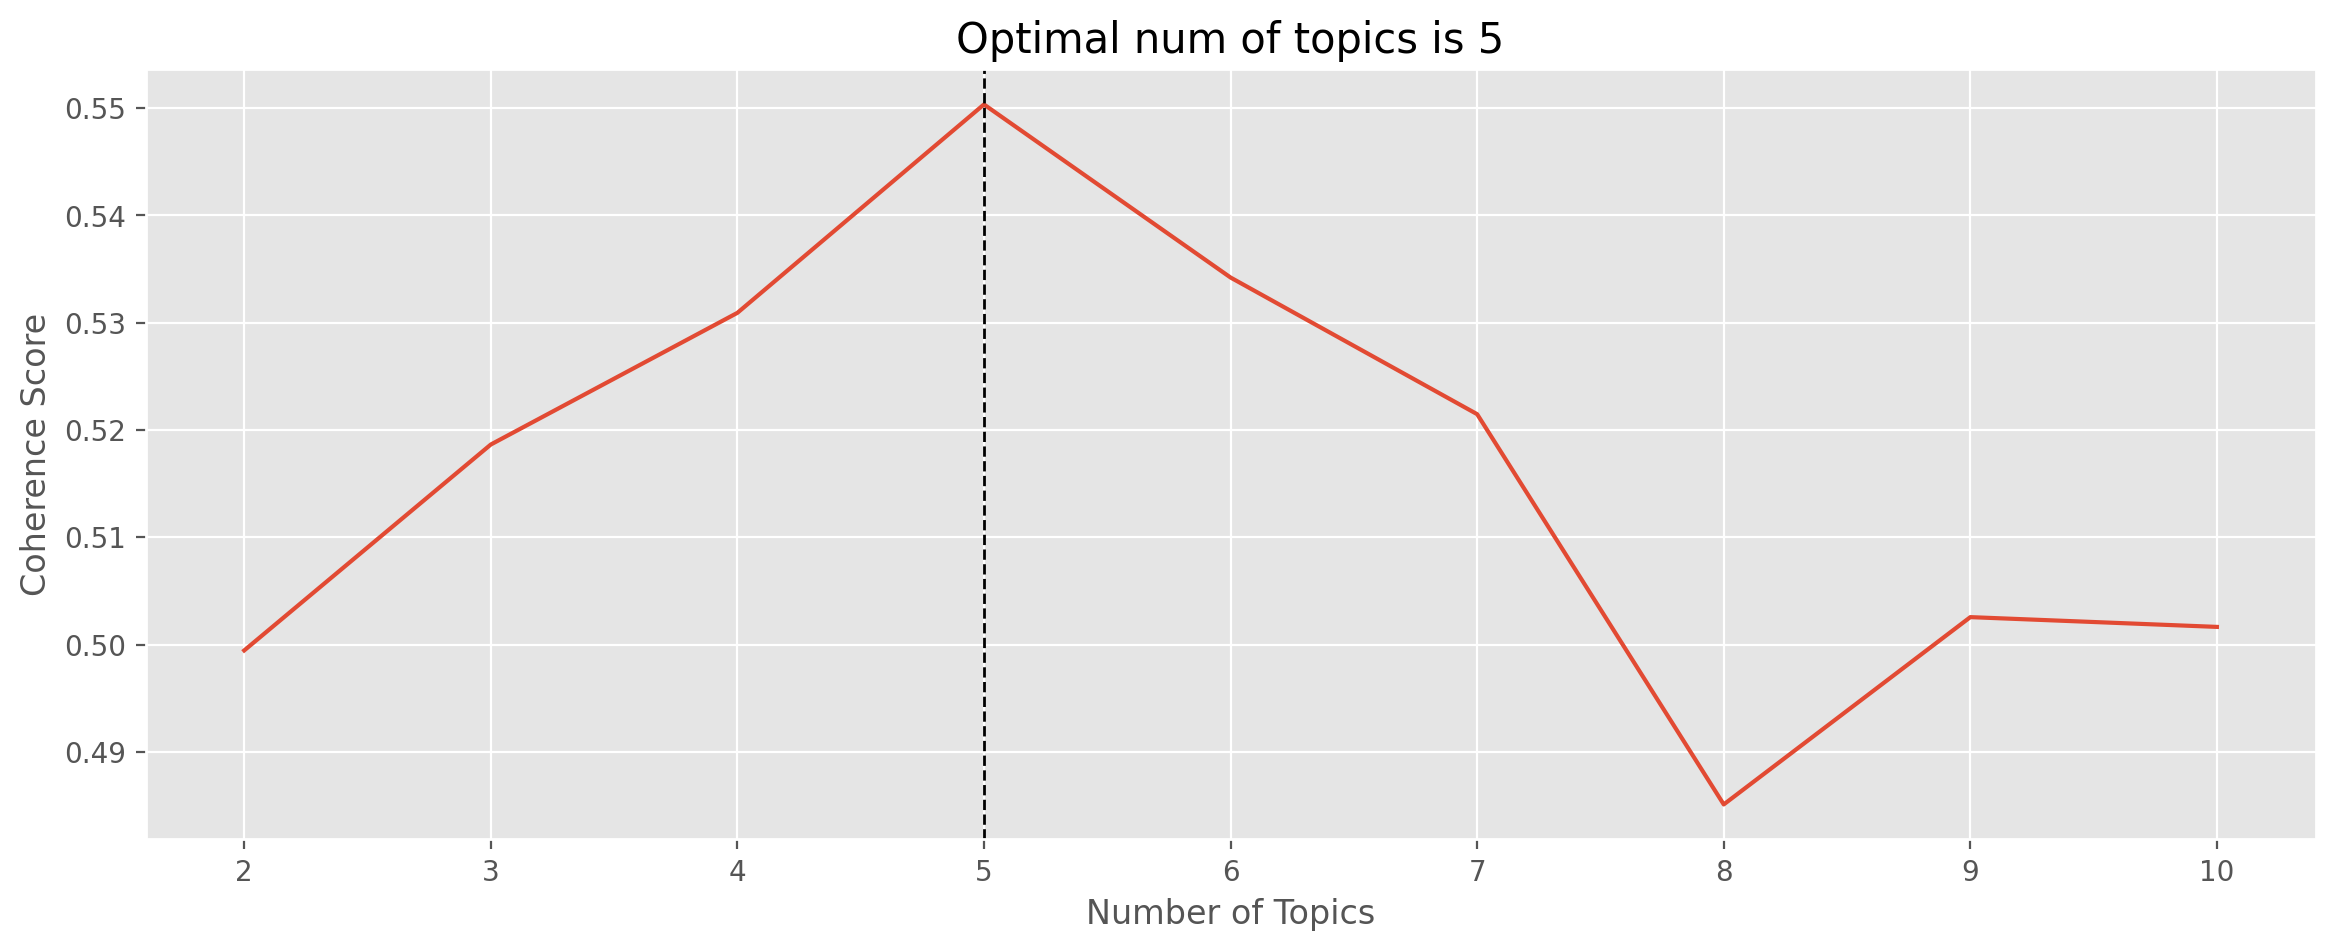

In [50]:
# Plot the coherence scores
plt.figure(figsize=(14, 5), dpi=200)
plt.plot(topics_range, coherence_scores)
plt.axvline(x=optimal_num_topics, linestyle='--', color='black', linewidth=1)
plt.xticks(range(2, 11, 1))
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title(f'Optimal num of topics is {optimal_num_topics}', size=15)
plt.show()

**Note**: Based on the grid search, an ideal number of topics for the reviews is 5. For this reason, this optimal number should be used for training LDA model. And since grid search involving number of topics has been done, hyperparameter tuning later will not need to include the same parameter anymore to save the time.

### **4.3 LDA Model Training**

In [51]:
# train LDA model
start_time = time.time()
lda_model = LdaModel(corpus=corpus,
                     num_topics=optimal_num_topics,
                     id2word=dictionary,
                     random_state=42,
                     passes=20)
end_time = time.time()
print(f'Time taken for model training: {end_time - start_time:.2f} seconds')

Time taken for model training: 92.76 seconds


In [52]:
# compute coherence score
untuned_coherence_model = CoherenceModel(model=lda_model, texts=df4['tokens'],
                                 dictionary=dictionary, coherence='c_v')
untuned_coherence_score = untuned_coherence_model.get_coherence()

# calculate perplexity
untuned_perplexity = lda_model.log_perplexity(corpus)
untuned_perplexity_value = np.exp(-untuned_perplexity)

# print output
print(f'Coherence score: {untuned_coherence_score:.4f}')
print(f'Perplexity: {untuned_perplexity_value:.4f}')

Coherence score: 0.5503
Perplexity: 1345.6066


**Note**: The coherence score indicates that in general, the semantic interpretability of topics is moderate (0.55). This moderate coherence is normal since app reviews normally cover broad range of feedback.

### **4.4 Hyperparameter Tuning**
In the [documentation]((https://radimrehurek.com/gensim/models/ldamodel.html)) of Gensim, there are plenty of parameters such as `passes`, `alpha`, `eta`, `iterations`, and `num_topics`, to name a few, can be specified for a Latent Dirichlet Allocation model. However, I decided to use `alpha` and `iterations` for hyperparameter tuning process. One main reason is due to the more parameters, the higher computational resource and training time involves. `num_topics` will not be utilized again since it has been used during grid search to obtain the optimal number of topics based on coherence score. 

In [53]:
# set hyperapram grid
param_grid = {
    'alpha': ['auto', 0.01, 0.1, 1.0],
    'iterations': [100, 200]
}

grid = ParameterGrid(param_grid)

**Note**: Above I set two parameters for grid search, namely `iterations` and `alpha`. `iterations` is concerned with how well the model converges to a stable solution. Insufficient iterations can lead to failure in capturing underlying structure of the data. One way to identify this issue is from the small topic coherence score. Second, I also set `alpha` which controls the distribution of topics per documents. A very low alpha value can cause the model to be overfitting and a very high value can lead to mixing too much topic (underfitting). Grid search attempts to search the best possible combination of parameters based on coherence score as the primary metric of evaluation in this project.

In [54]:
best_coherence = -1
best_params = {}

for params in grid:
    start_time = time.time()
    # train the LDA model
    tuned_lda_model = LdaModel(corpus=corpus,
                         num_topics=optimal_num_topics,
                         id2word=dictionary,
                         alpha=params['alpha'],
                         passes=20,
                         iterations=params['iterations'],
                         random_state=42)
    # calculate coherence score
    coherence_model = CoherenceModel(model=tuned_lda_model, texts=df4['tokens'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Params: {params}, coherence score: {coherence_score:.4f}, TT: {elapsed_time:.2f} seconds")

    # update the best score and parameters
    if coherence_score > best_coherence:
        best_coherence = coherence_score
        best_params = params

print(f"Best coherence score: {best_coherence:.4f} with params: {best_params}")

Params: {'alpha': 'auto', 'iterations': 100}, coherence score: 0.5015, TT: 82.63 seconds
Params: {'alpha': 'auto', 'iterations': 200}, coherence score: 0.5035, TT: 82.82 seconds
Params: {'alpha': 0.01, 'iterations': 100}, coherence score: 0.5308, TT: 100.79 seconds
Params: {'alpha': 0.01, 'iterations': 200}, coherence score: 0.5465, TT: 99.12 seconds
Params: {'alpha': 0.1, 'iterations': 100}, coherence score: 0.5358, TT: 95.66 seconds
Params: {'alpha': 0.1, 'iterations': 200}, coherence score: 0.5340, TT: 96.68 seconds
Params: {'alpha': 1.0, 'iterations': 100}, coherence score: 0.5616, TT: 80.10 seconds
Params: {'alpha': 1.0, 'iterations': 200}, coherence score: 0.5616, TT: 79.64 seconds
Best coherence score: 0.5616 with params: {'alpha': 1.0, 'iterations': 100}


In [55]:
# train LDA model w/ opt param
start_time = time.time()
tuned_lda_model = LdaModel(corpus=corpus,
                     num_topics=optimal_num_topics,
                     id2word=dictionary,
                     random_state=42,
                     alpha=1.0,
                     iterations=100,
                     passes=20)
end_time = time.time()
print(f'Time taken for model training: {end_time - start_time:.2f} seconds')

Time taken for model training: 76.45 seconds


In [56]:
# compute coherence score
tuned_coherence_model = CoherenceModel(model=tuned_lda_model, texts=df4['tokens'],
                                 dictionary=dictionary, coherence='c_v')
tuned_coherence_score = tuned_coherence_model.get_coherence()

# calculate perplexity
tuned_perplexity = tuned_lda_model.log_perplexity(corpus)
tuned_perplexity_value = np.exp(-tuned_perplexity)

# print output
print(f'Coherence score: {tuned_coherence_score:.4f}')
print(f'Perplexity: {tuned_perplexity_value:.4f}')

Coherence score: 0.5616
Perplexity: 1242.3516


### **4.5 Evaluation and Explanation**

#### **3.5.1 Model Comparison**

In [58]:
# model comparison
pd.DataFrame({
    'Metric': ['UntunedCoherenceScore', 'UntunedPerplexity', 'TunedCoherenceScore', 'TunedPerplexity'],
    'Score': [untuned_coherence_score, untuned_perplexity_value, tuned_coherence_score, tuned_perplexity_value],
}).round(2)

Metric    Score
0  UntunedCoherenceScore     0.55
1      UntunedPerplexity  1345.61
2    TunedCoherenceScore     0.56
3        TunedPerplexity  1242.35

**Note**: As the tuned LDA model has better performance based on coherence and perplexity scores, the tuned version will be selected for topic extraction and model explanation. After hyperparameter tuning, the perplexity score decreased by 103 and the coherence score increased by 0.01. In spite of showing some improvements, the changes are not significant.

#### **4.5.2 Topic Extraction**

In [59]:
# display the top 10 words for each topic
for idx, topic in tuned_lda_model.show_topics(num_topics=5, num_words=10, formatted=False):
    print(f"Topic {idx}: {[word for word, _ in topic]}")

Topic 0: ['gopay', 'aplikasi', 'pake', 'gak', 'ribet', 'gojek', 'pembayaran', 'pakai', 'fitur', 'akun']
Topic 1: ['mantap', 'ok', 'good', 'semoga', 'apk', 'keren', 'oke', 'app', 'pokoknya', 'sukses']
Topic 2: ['ga', 'top', 'saldo', 'udah', 'pulsa', 'uang', 'beli', 'masuk', 'up', 'transfer']
Topic 3: ['__num__', 'bayar', 'ya', 'kasih', 'kota', 'bintang', 'coba', 'nih', 'tf', 'mempermudah']
Topic 4: ['bagus', 'mudah', 'membantu', 'banget', 'transaksi', 'aplikasinya', 'transfer', 'cepat', 'gratis', 'memudahkan']


**Note**
- **Topic 0**: This topic seems to focus on the Gopay application. Words like "gopay," "aplikasi," and "pembayaran" suggest that users discuss features and functionalities related to payment services. Words like "ribet" (complicated) imply user challenges.
- **Topic 1**: This topic is characterized by positive feedback about the app. Words like "mantap" (great) and "keren" (cool) reflect user satisfaction. "Semoga" (hopefully) may indicate anticipation for future improvements or features.
- **Topic 2**: This topic appears to revolve around financial transactions. Keywords like "saldo" (balance), "uang" (money), and "transfer" suggest discussions related to managing money and transactions within the app.
- **Topic 3**: This topic appears to revolve around financial transactions. Keywords like "saldo" (balance), "uang" (money), and "transfer" suggest discussions related to managing money and transactions within the app.
- **Topic 4**: This topic highlights user benefits and ease of use. Terms like "bagus" (good), "mudah" (easy), and "gratis" (free) suggest that users find the app useful and beneficial for conducting transactions quickly and easily.

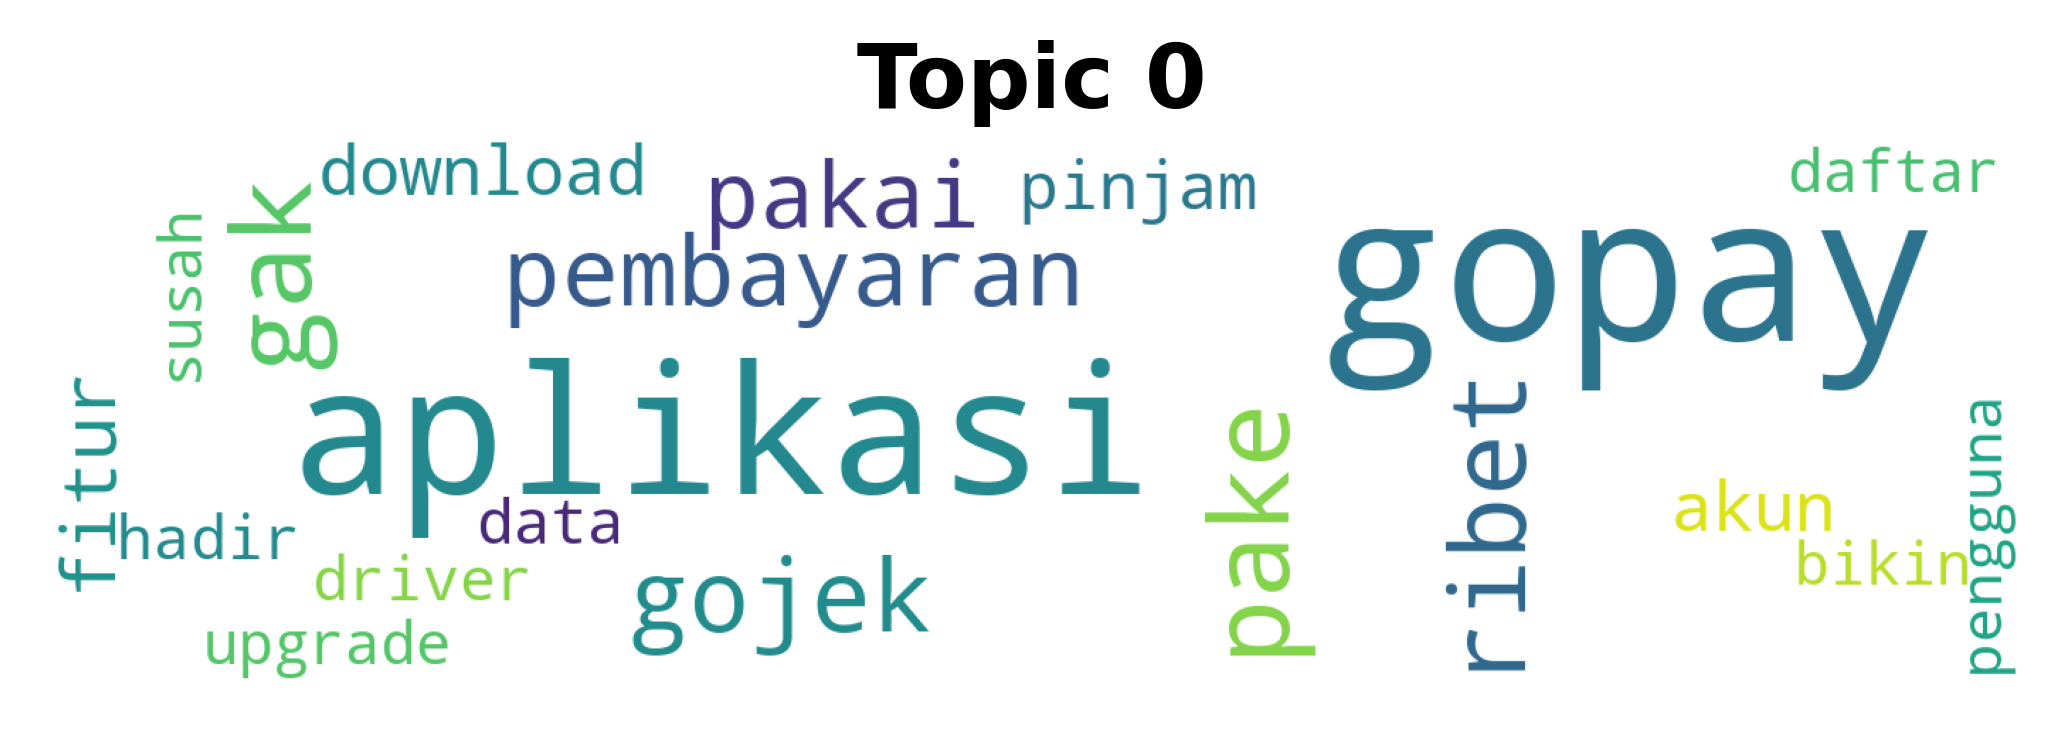

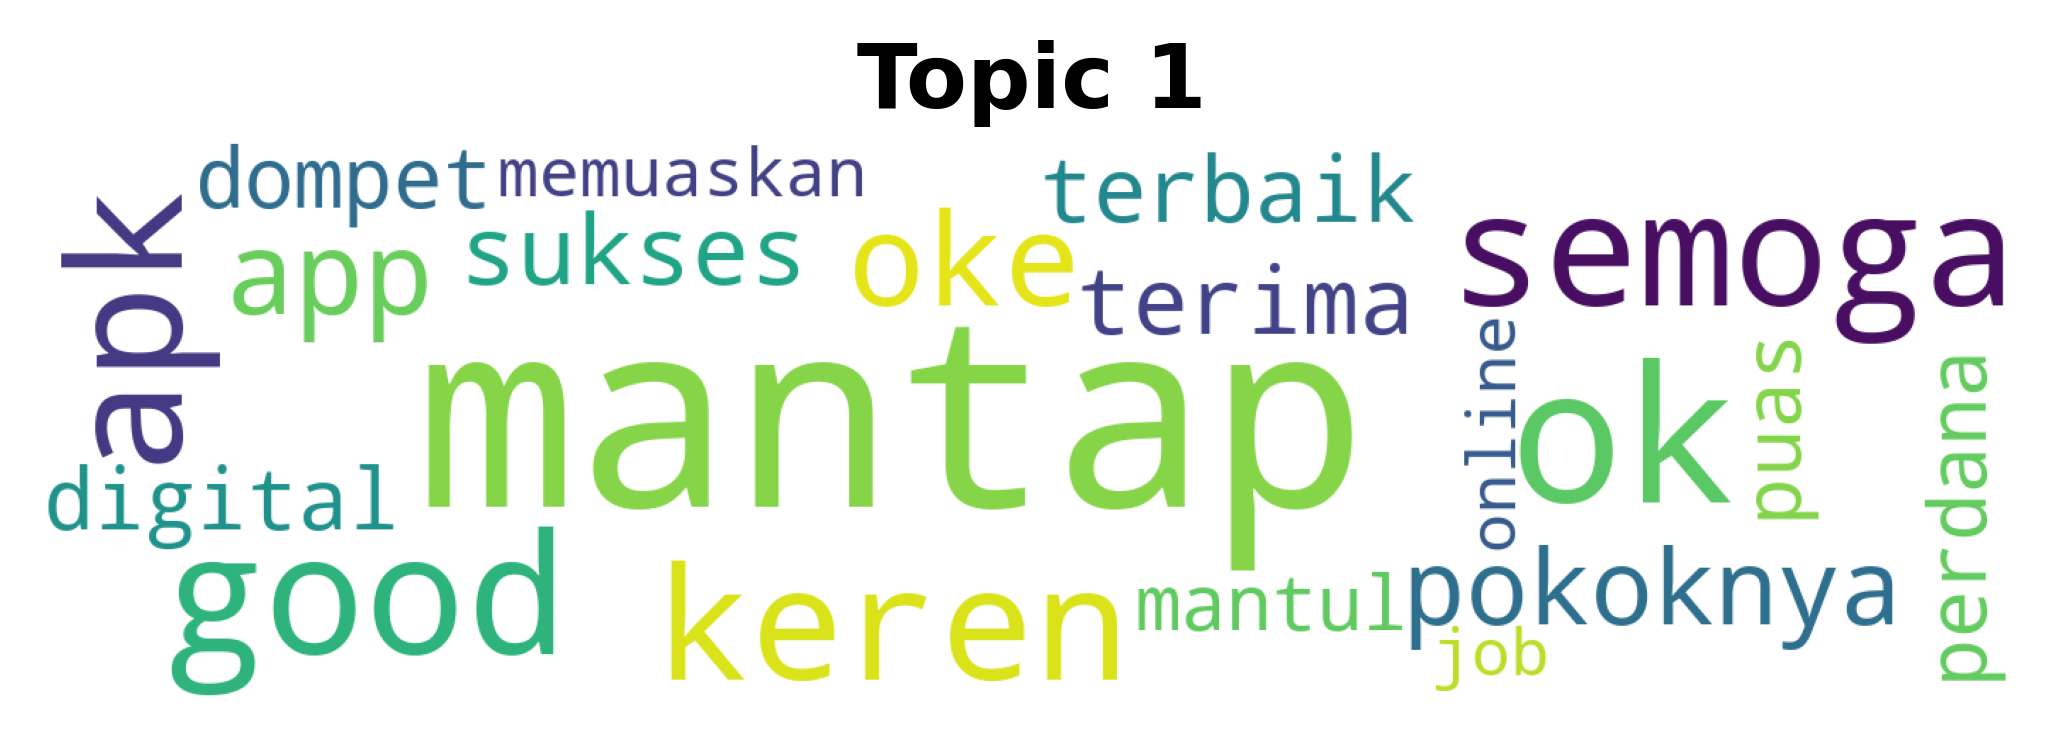

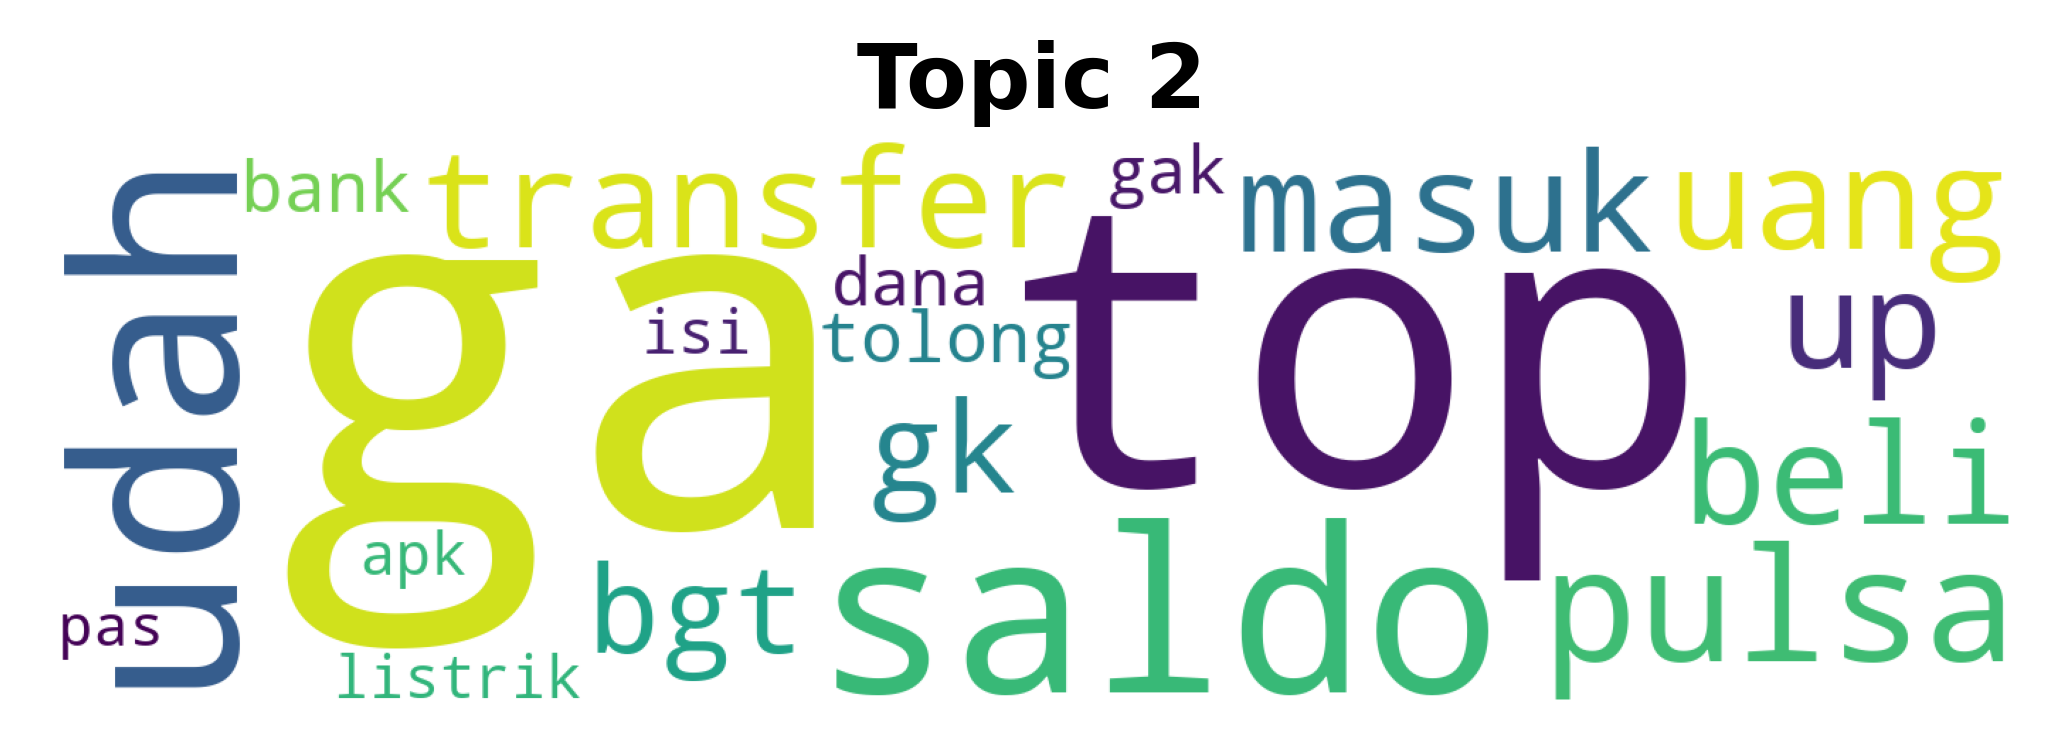

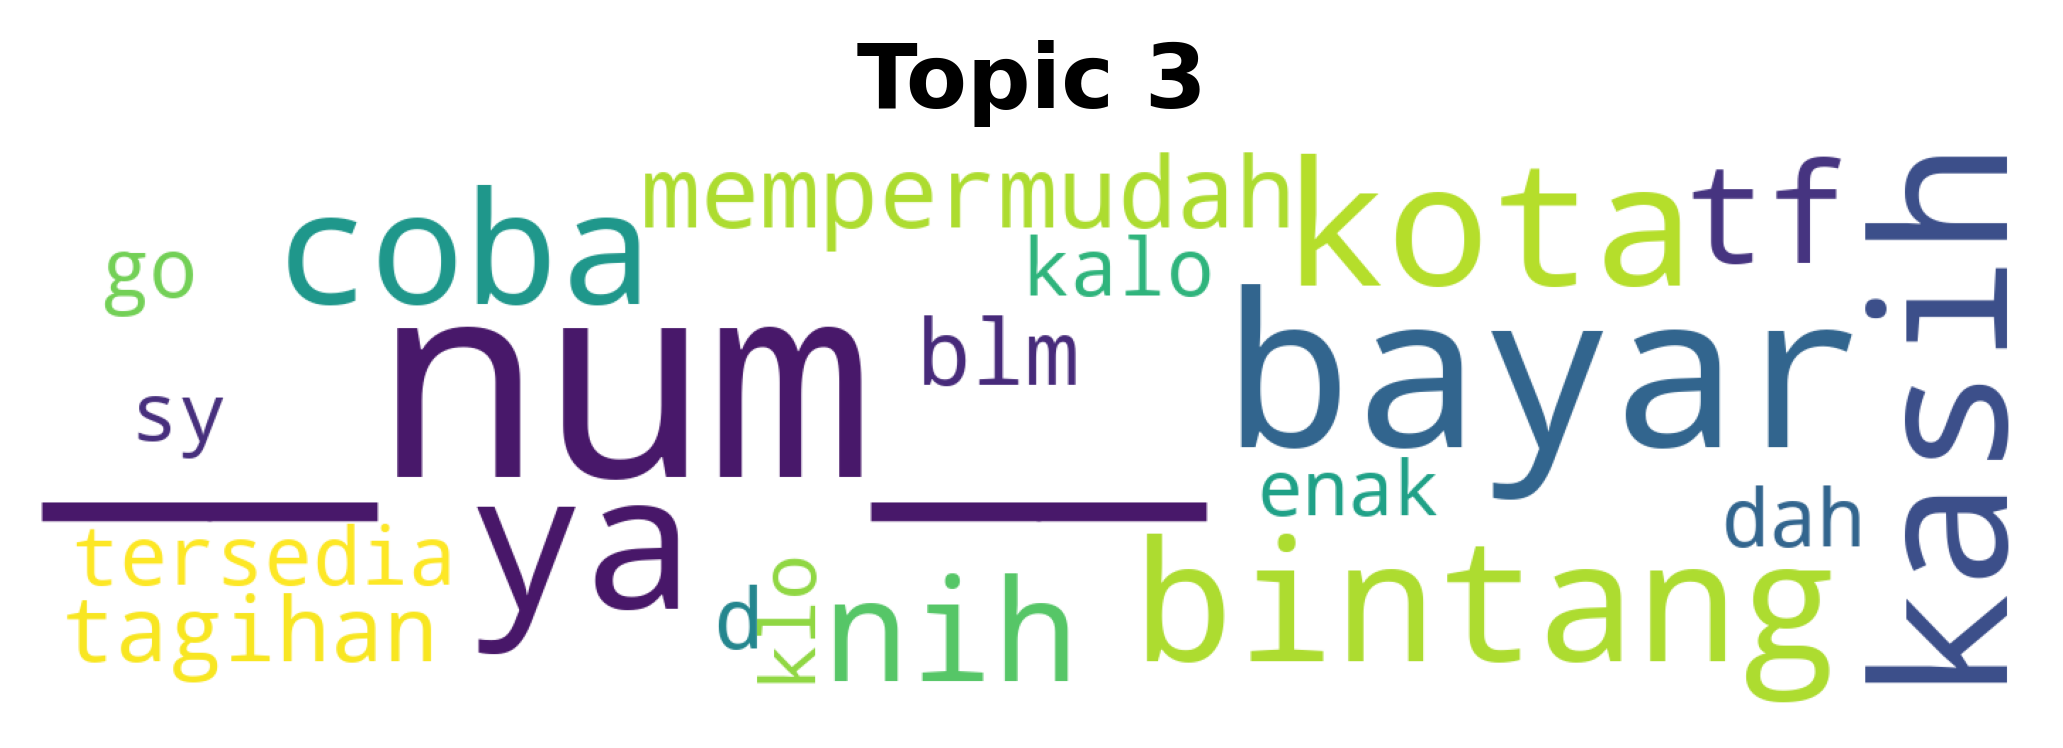

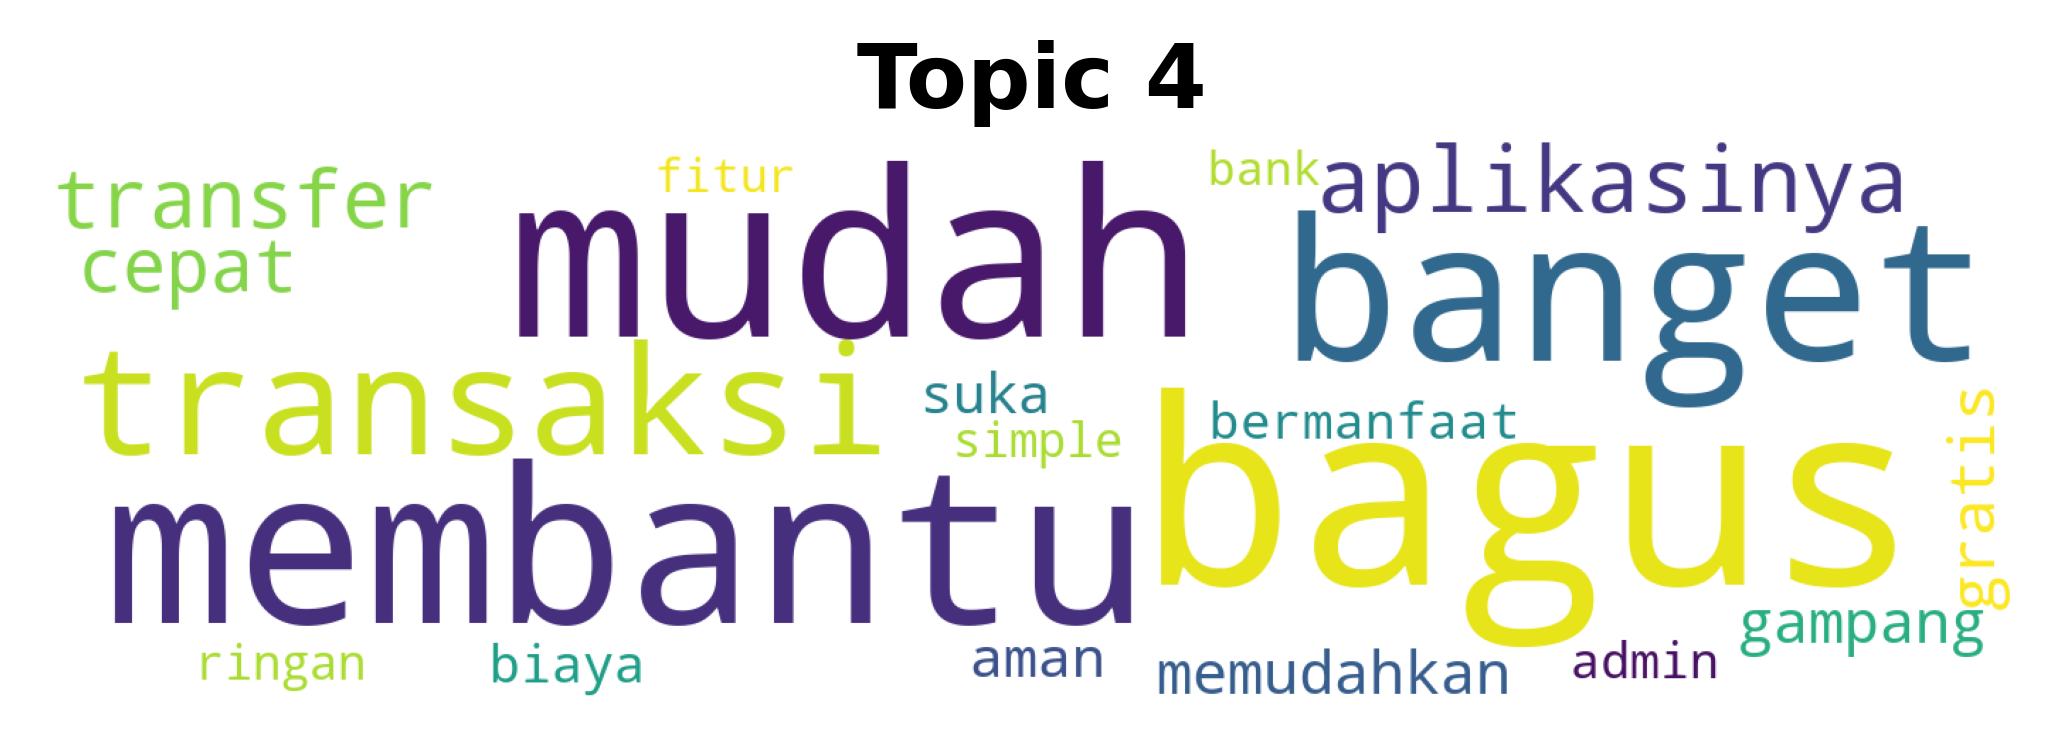

In [60]:
# generate word clouds for each topic
for idx in range(tuned_lda_model.num_topics):
    plt.figure(dpi=400)  # Increased DPI
    wordcloud = WordCloud(width=1400, height=400, background_color='white')\
                .fit_words(dict(tuned_lda_model.show_topic(idx, topn=20)))

    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f'Topic {idx}', size=16, weight='bold')
    plt.show()

#### **4.5.3 Topic Distribution**

In [61]:
# init topics with default value
df4['topic'] = -1

# loop over each document and assign the most probable topic
for i, doc_bow in enumerate(corpus):
    if doc_bow:  
        topic_assignment = tuned_lda_model.get_document_topics(doc_bow)
        if topic_assignment:
            df4.at[i, 'topic'] = max(topic_assignment, key=lambda x: x[1])[0]

display(df4.head())

userName                                            content  score  \
0  Pengguna Google                                             Mantap      5   
1  Pengguna Google                          Bagus dan mudah digunakan      5   
2  Pengguna Google                                               Good      5   
3  Pengguna Google  Sangat membantu orang menengah mantap semoga s...      5   
4  Pengguna Google                                Ga ribet .. Sukaaaa      5   

   thumbsUpCount reviewCreatedVersion                  at  \
0              0               1.24.1 2024-07-07 16:58:06   
1              0               1.24.1 2024-07-07 16:57:08   
2              0               1.24.1 2024-07-07 16:52:38   
3              0               1.24.1 2024-07-07 16:52:36   
4              0               1.24.1 2024-07-07 16:52:09   

                                              tokens  topic  
0                                           [mantap]      1  
1                                     [bagus, mudah]      4  
2                                             [good]      1  
3  [membantu, orang, menengah, mantap, semoga, su...      1  
4                               [ga, ribet, sukaaaa]      0

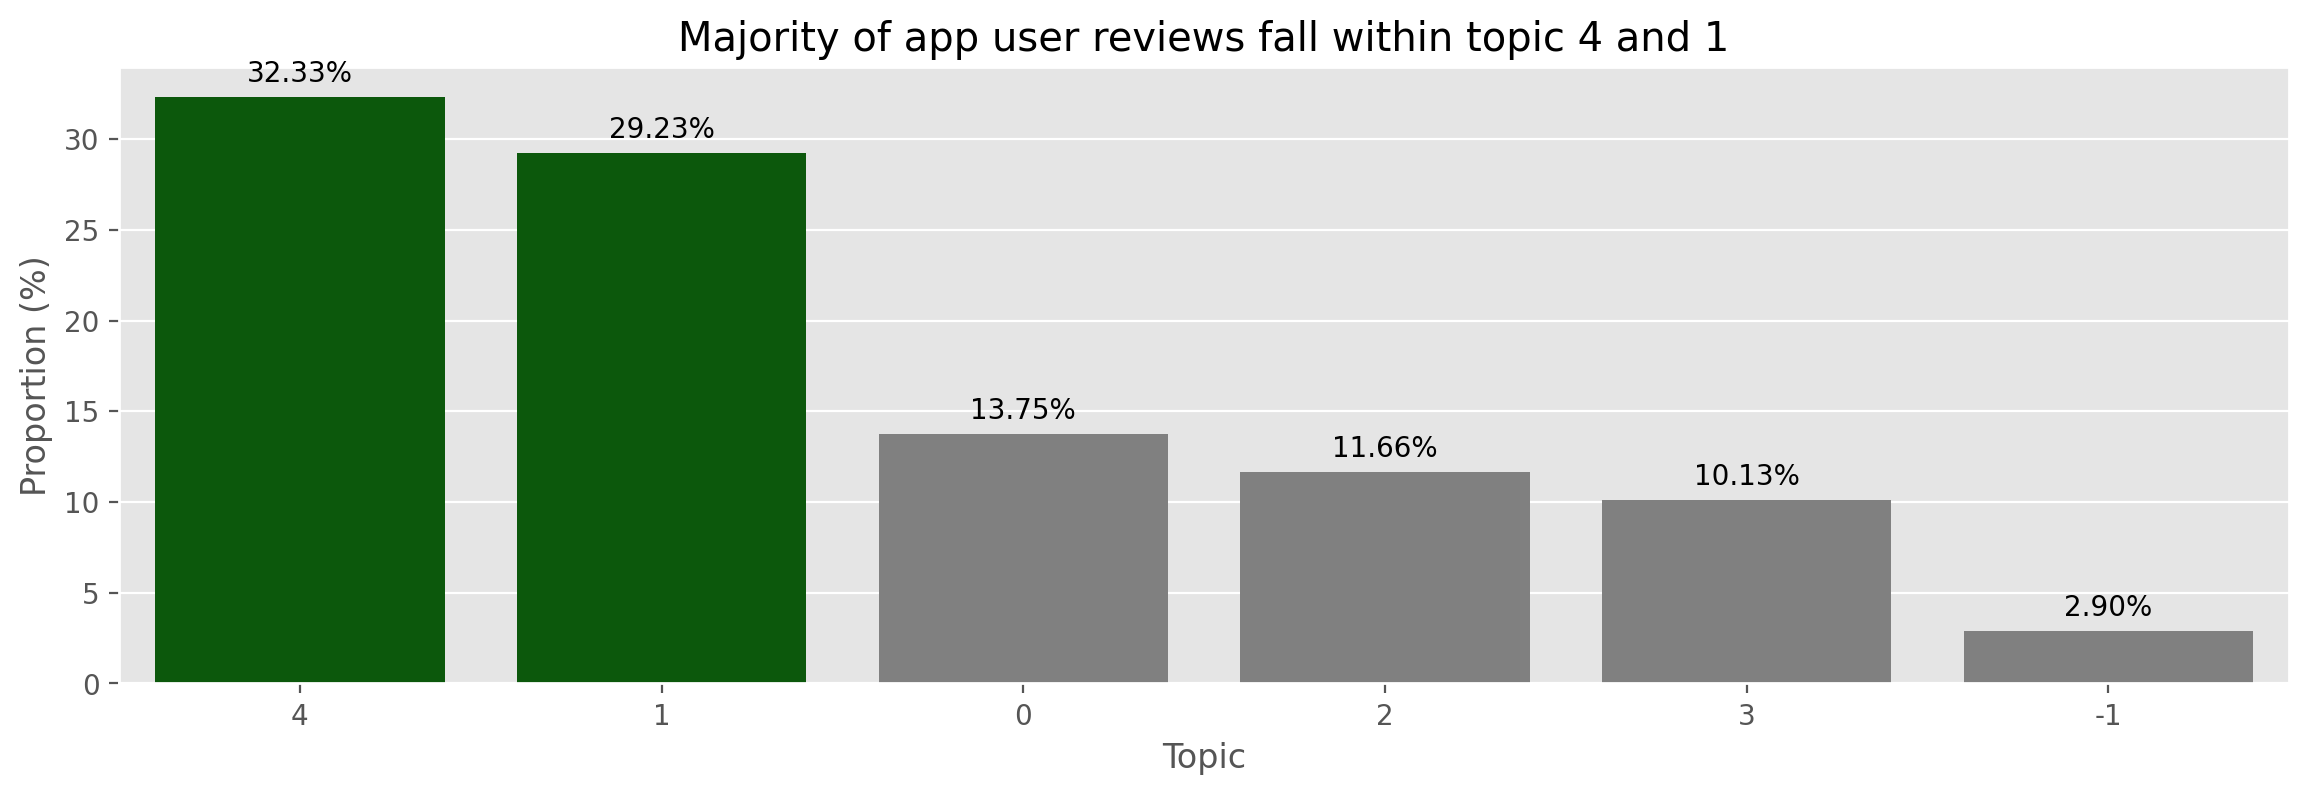

In [62]:
# prepare data
topic_proportion = (df4['topic'].value_counts(normalize=True)*100).reset_index().round(2)
topic_proportion['topic'] = topic_proportion['topic'].astype(str)
topic_proportion = topic_proportion.sort_values(by='proportion', ascending=False)

# set figure size
plt.figure(figsize=(14, 4), dpi=200)

# highlight topic 1 and 4
highlight_colors = ['darkgreen' if topic in ['1', '4'] else 'grey' for topic in topic_proportion['topic']]

# make bar chart
sns.barplot(y='proportion', x='topic', data=topic_proportion, hue='topic',
            palette=highlight_colors)

for index, row in topic_proportion.iterrows():
    plt.text(row.name, row['proportion'] + 0.5, f'{row["proportion"]:.2f}%', 
             ha='center', va='bottom', fontsize=10)

plt.title('Majority of app user reviews fall within topic 4 and 1')
plt.xlabel('Topic')
plt.ylabel('Proportion (%)')
plt.show()

In [63]:
# prepare data
topic_distribution = np.zeros((len(df4), tuned_lda_model.num_topics))
for i, item in enumerate(corpus):
    if item:
        topic_info = lda_model.get_document_topics(item)
        for topic_id, prob in topic_info:
            topic_distribution[i, topic_id] = prob

topic_df = pd.DataFrame(topic_distribution,
                        columns=[f'Topic {i}' for i in range(tuned_lda_model.num_topics)])

topic_df.head(10)

Topic 0   Topic 1   Topic 2   Topic 3   Topic 4
0  0.100000  0.100000  0.100000  0.600000  0.100000
1  0.066667  0.066667  0.066667  0.066667  0.733333
2  0.100000  0.100000  0.599998  0.100000  0.100000
3  0.025339  0.774360  0.025181  0.150047  0.025073
4  0.454717  0.050135  0.050547  0.050137  0.394465
5  0.100000  0.599999  0.100000  0.100000  0.100000
6  0.548104  0.050617  0.050379  0.300514  0.050387
7  0.050000  0.050000  0.050000  0.800000  0.050000
8  0.238670  0.440805  0.040056  0.040057  0.240412
9  0.100259  0.100260  0.100260  0.100264  0.598957

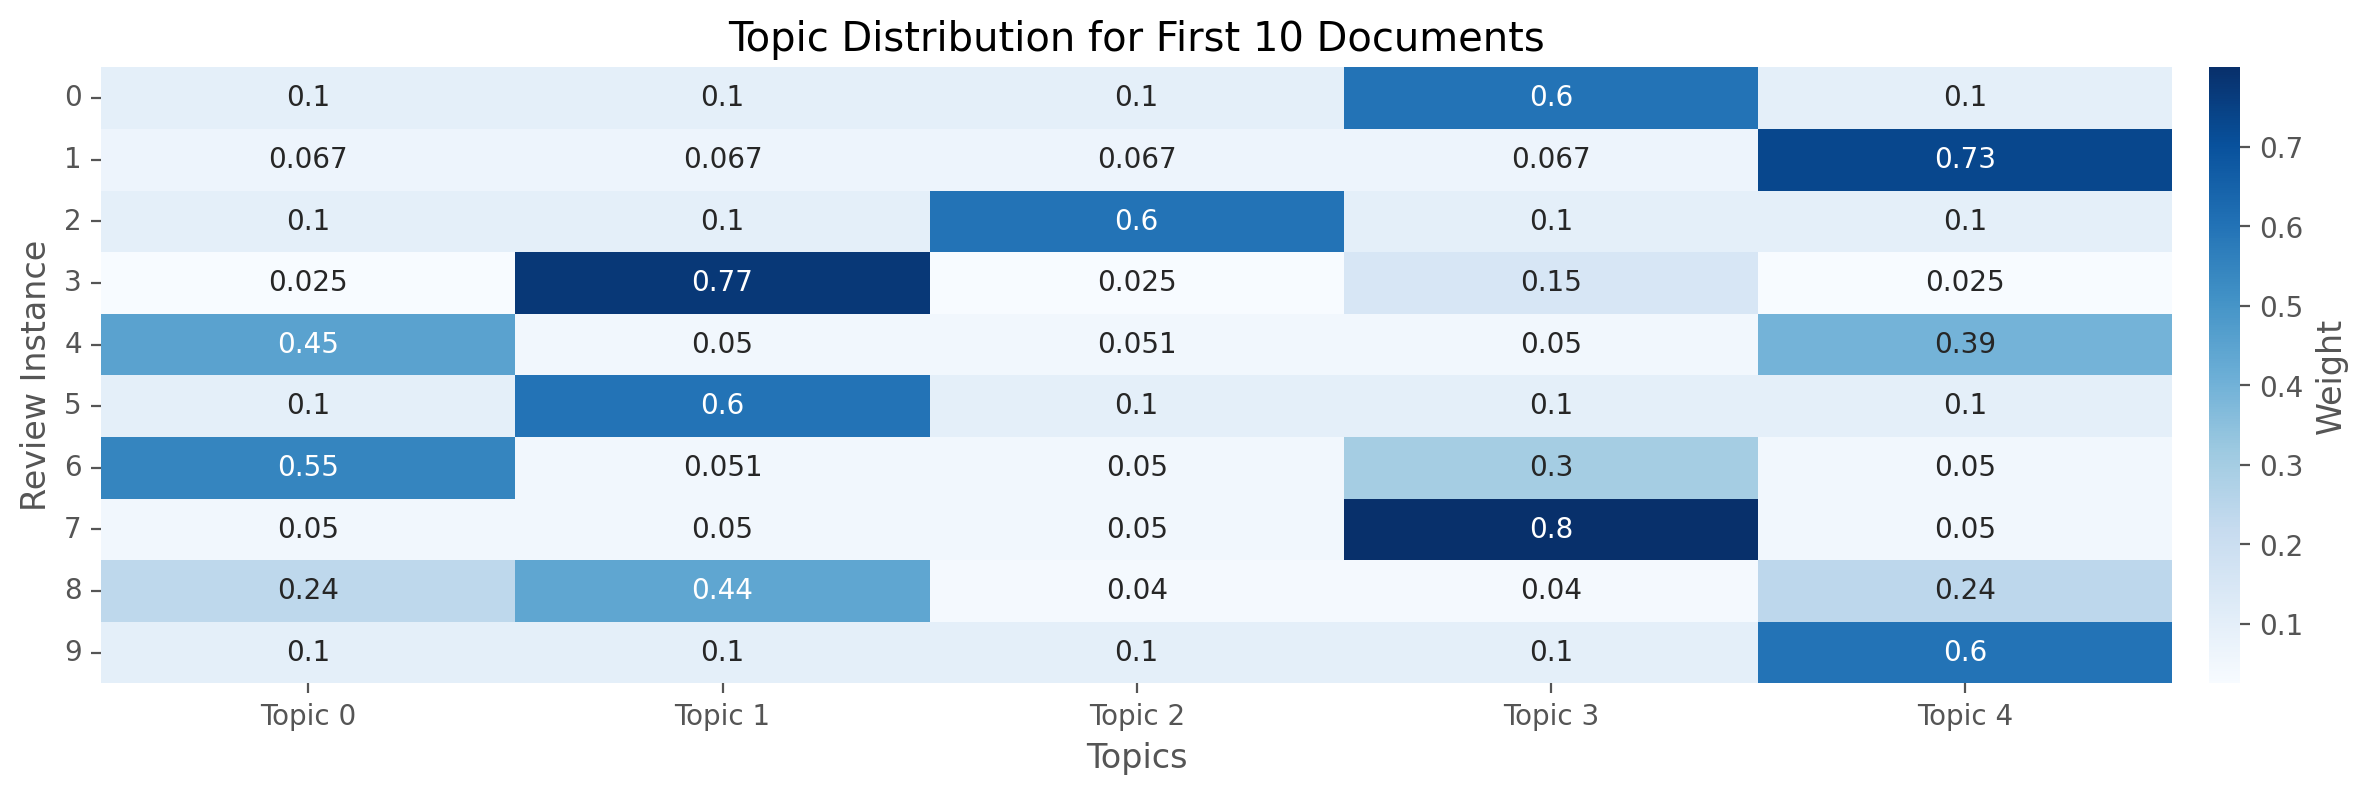

In [64]:
# visualize topic distribution for top-10 instance
plt.figure(figsize=(16, 4), dpi=200)
sns.heatmap(topic_df.iloc[:10], cmap='Blues', annot=True, cbar_kws={'label': 'Weight', 'pad': 0.015})
plt.title('Topic Distribution for First 10 Documents')
plt.ylabel('Review Instance')
plt.xlabel('Topics')
plt.yticks(rotation=0)
plt.show()

##### **4.5.3.1 Why were some instances unclassified into certain topics?**
Some instances can be unclassified due to a number of reasons such as topic overlap (mixture of terms from different topics), short document length (not enough information to infer the topic group), and model limitation (not the best model). The first and second points can be tested directly in this notebook whereas for the last point, I need to compare different topic models to understand whether the small amount of unclassified reviews is due to the limitation of Latent Dirichlet Allocation. For the overlap between topics, I can investigate it by firstly checking whether there are terms present in different topics. If not found, I will test the potential overlapping topics by using cosine similarity.

In [65]:
# Locate unclassified instances
unclassified_ins = df4[df4['topic'] == -1].copy()  
unclassified_ins.loc[:, 'review_len'] = unclassified_ins['content'].str.split().str.len()  
print(f"Total unclassified instances: {len(unclassified_ins)}")
unclassified_ins.loc[:, ['userName', 'content', 'review_len', 'score', 'tokens', 'topic']].head()

Total unclassified instances: 3571


userName                                            content  \
119682  Pengguna Google                                        Mantaap....   
119683  Pengguna Google                                             Mantap   
119684  Pengguna Google  Mantap pembayaran lebih mudah dan cepat ga pke...   
119685  Pengguna Google                                            Ok dulu   
119686  Pengguna Google          Keterangan maaf kami belum hadir dikotamu   

        review_len  score                                             tokens  \
119682           1      5                                          [mantaap]   
119683           1      5                                           [mantap]   
119684           9      5  [mantap, pembayaran, mudah, cepat, ga, pke, ri...   
119685           2      5                                               [ok]   
119686           6      3                [keterangan, maaf, hadir, dikotamu]   

        topic  
119682     -1  
119683     -1  
119684     -1  
119685     -1  
119686     -1

In [66]:
pd.options.display.max_colwidth=None

# extract the topics and their word distributions 
topics_data = tuned_lda_model.show_topics(formatted=False)

# prepare a list to store formatted topics
formatted_topics = []
for idx, topic in topics_data:
    formatted_topic = ', '.join([f"({word}, {weight:.2f})" for word, weight in topic])
    formatted_topics.append((idx, formatted_topic))

# create a df
topics_df = pd.DataFrame(formatted_topics, columns=['n_topic', 'top_words'])
display(topics_df)

n_topic  \
0        0   
1        1   
2        2   
3        3   
4        4   

                                                                                                                                                                     top_words  
0                     (gopay, 0.17), (aplikasi, 0.13), (pake, 0.03), (gak, 0.03), (ribet, 0.03), (gojek, 0.02), (pembayaran, 0.02), (pakai, 0.02), (fitur, 0.01), (akun, 0.01)  
1                             (mantap, 0.16), (ok, 0.07), (good, 0.05), (semoga, 0.05), (apk, 0.05), (keren, 0.05), (oke, 0.03), (app, 0.02), (pokoknya, 0.02), (sukses, 0.02)  
2                                 (ga, 0.04), (top, 0.03), (saldo, 0.02), (udah, 0.02), (pulsa, 0.02), (uang, 0.02), (beli, 0.02), (masuk, 0.02), (up, 0.02), (transfer, 0.02)  
3                         (__num__, 0.06), (bayar, 0.03), (ya, 0.03), (kasih, 0.03), (kota, 0.02), (bintang, 0.02), (coba, 0.02), (nih, 0.01), (tf, 0.01), (mempermudah, 0.01)  
4  (bagus, 0.10), (mudah, 0.08), (membantu, 0.07), (banget, 0.06), (transaksi, 0.04), (aplikasinya, 0.04), (transfer, 0.03), (cepat, 0.03), (gratis, 0.02), (memudahkan, 0.02)

**Note**: Based on a formal inspection, there are no words found in multiple topics based on the topic distributions. But a few indications can still be found when taking meaning into account. For example, topic 1 (*mantap*, *ok*) and topic 4 (*bagus*, *mudah*, *membantu*) both capture general positive sentiment to express satisfaction. Topic 2 (*saldo*, *uang*, and *beli*) and topic 3 (*bayar*, *tf*) refer to financial transactions (payments). While the semantic grouping may not be a definitive answer for the topic overlap, this may provide a basis for a further analysis.

In [67]:
# check topic overlap
word_topic_matrix = tuned_lda_model.get_topics()
similarity_matrix = cosine_similarity(word_topic_matrix)

# convert matrix to df
similarity_df = pd.DataFrame(similarity_matrix, 
                             columns=[f'Topic {i}' for i in range(similarity_matrix.shape[1])],
                             index=[f'Topic {i}' for i in range(similarity_matrix.shape[0])])

# display cosine similarity matrix
display(similarity_df.round(4))

Topic 0  Topic 1  Topic 2  Topic 3  Topic 4
Topic 0   1.0000   0.0001   0.0205   0.0003   0.0032
Topic 1   0.0001   1.0000   0.0201   0.0004   0.0001
Topic 2   0.0205   0.0201   1.0000   0.0118   0.0560
Topic 3   0.0003   0.0004   0.0118   1.0000   0.0002
Topic 4   0.0032   0.0001   0.0560   0.0002   1.0000

**Note**: Cosine similarity is used to measure the extent to which different topics share similarities on the basis of word matrix (array) generated from LDA model (tuned). According to the dataframe of cosine similarity matrix, the degree of similarity between topics is small, indicating minor overlapping topics.

In [68]:
# add review len
df4['review_len'] = df4['content'].str.split().str.len()

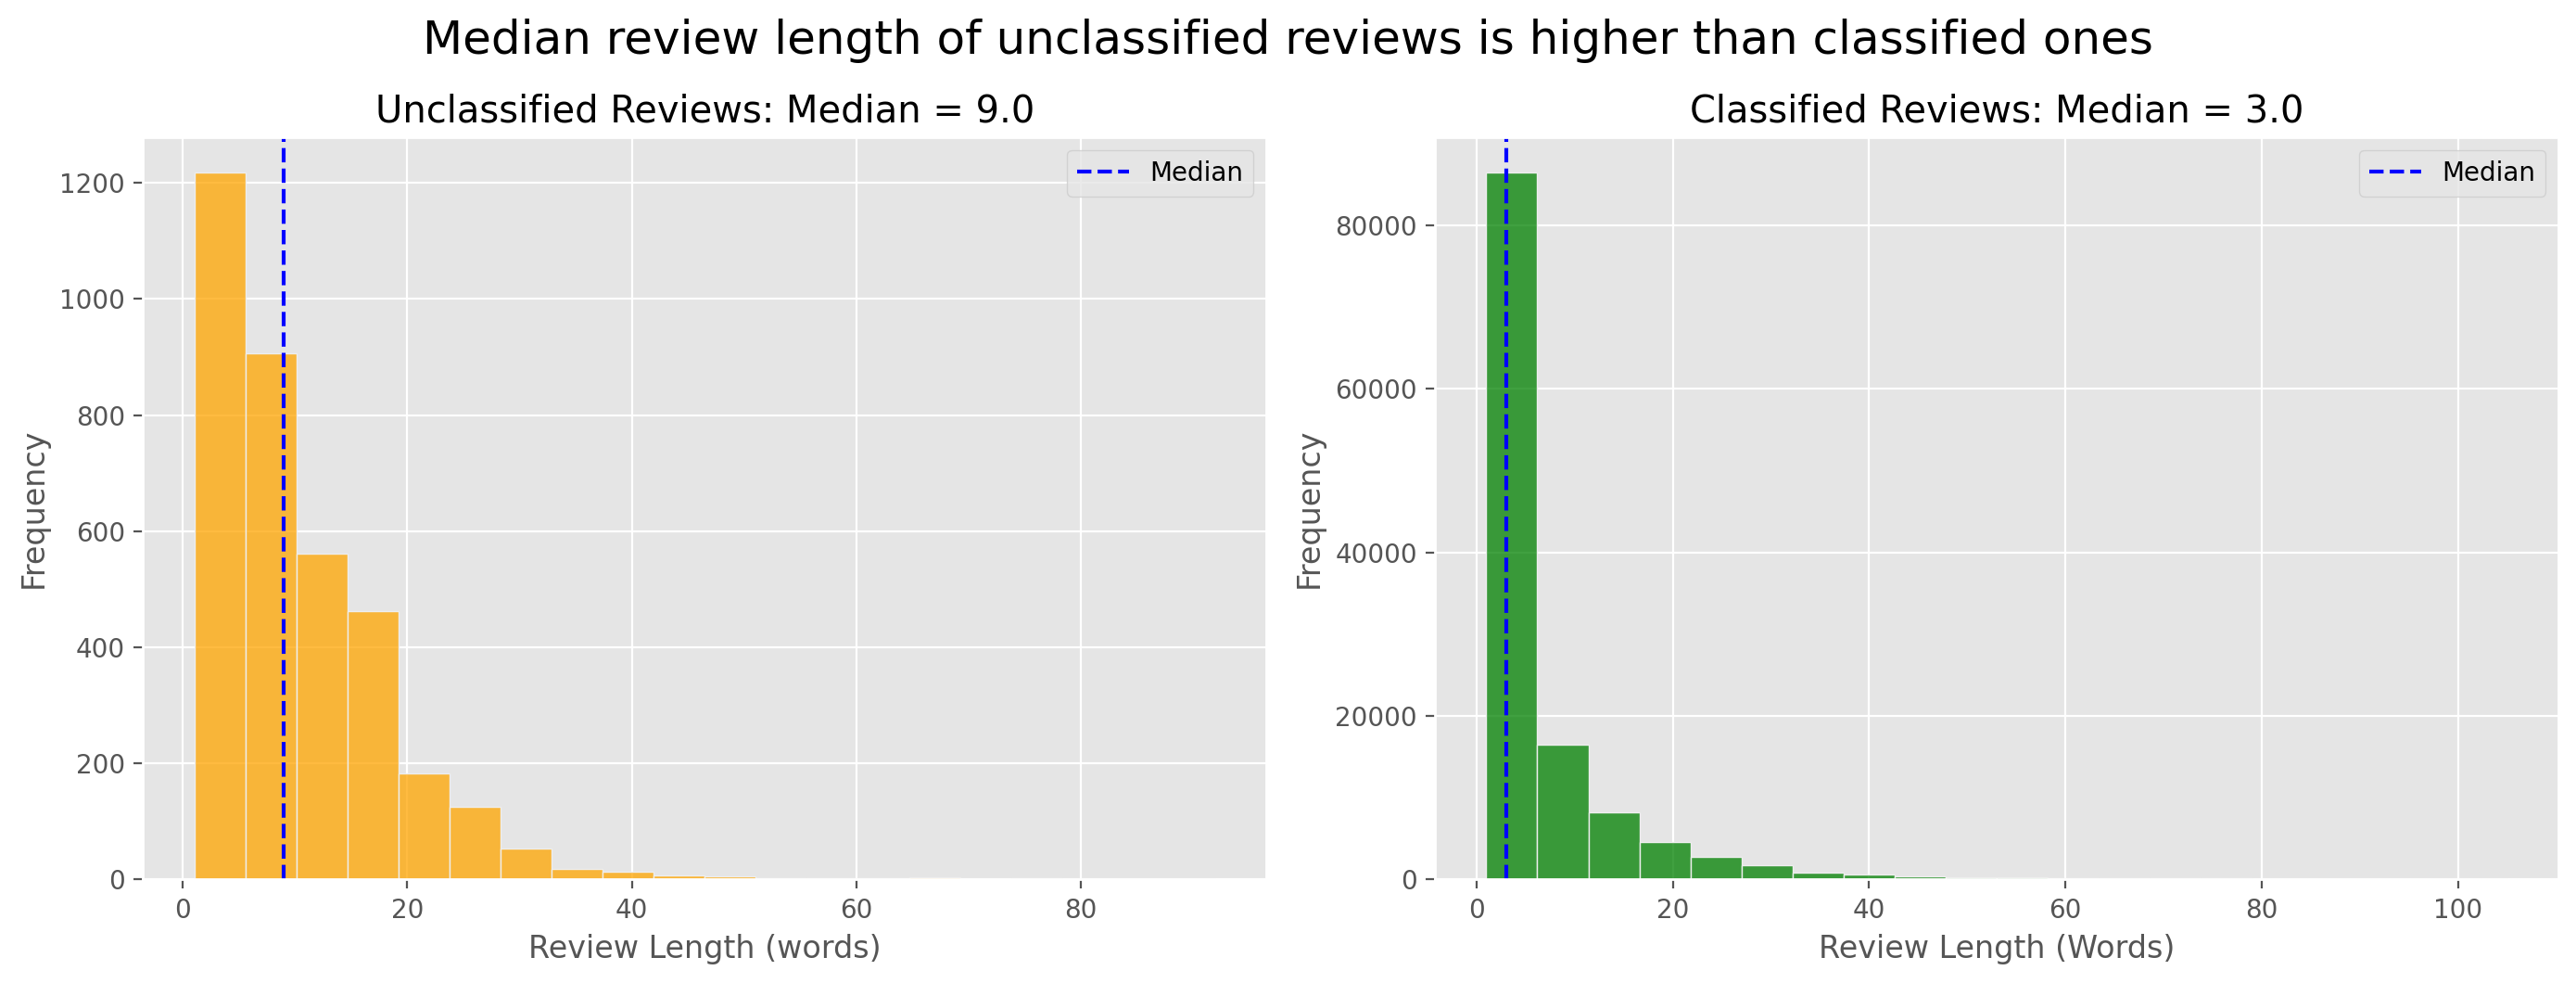

In [69]:
plt.figure(figsize=(14, 5), dpi=200)

# first subplot for unclassified reviews
median_unclassified = unclassified_ins['review_len'].median()
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(unclassified_ins['review_len'], bins=20, color='orange', kde=False)
plt.title(f'Unclassified Reviews: Median = {median_unclassified}')
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.axvline(median_unclassified, color='blue', linestyle='--', label='Median')
plt.legend()

# second subplot for classified reviews
median_classified = df4['review_len'].median()
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(df4['review_len'], bins=20, color='green', kde=False)
plt.title(f'Classified Reviews: Median = {median_classified}')
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')
plt.axvline(median_classified, color='blue', linestyle='--', label='Median')
plt.legend()

plt.tight_layout()
plt.suptitle('Median review length of unclassified reviews is higher than classified ones', 
             y=1.05, size=18)
plt.show()

**Note**: Instead of too short, the unclassified reviews tend to be longer in words than classified ones. This implies that review length may not be the main reason for some instances not classified.

the values between different topics (off-diagonal values) are very close to zero, suggesting very little overlap between the topics. 

In [70]:
# filter dataset
(df4[(df4['review_len'] == 1) & 
     (df4['content'].str.contains(r'[M|m]anta[p|b]', regex=True))]
 .head())

userName  content  score  thumbsUpCount reviewCreatedVersion  \
0   Pengguna Google   Mantap      5              0               1.24.1   
24  Pengguna Google   Mantap      5              0                  NaN   
40  Pengguna Google  Mantapo      5              0               1.24.1   
56  Pengguna Google   Mantab      5              0               1.24.1   
57  Pengguna Google   Mantap      5              0               1.19.0   

                    at     tokens  topic  review_len  
0  2024-07-07 16:58:06   [mantap]      1           1  
24 2024-07-07 15:45:19   [mantap]      0           1  
40 2024-07-07 14:55:18  [mantapo]      3           1  
56 2024-07-07 14:05:50   [mantab]      3           1  
57 2024-07-07 14:05:00   [mantap]      1           1

In [71]:
# filter unclassified instance (-1)
(unclassified_ins[(unclassified_ins['review_len'] == 1) & 
                 (unclassified_ins['content'].str.contains(r'[M|m]anta[p|b]', regex=True))]
 .head())

userName content  score  thumbsUpCount reviewCreatedVersion  \
119683  Pengguna Google  Mantap      5              0                1.4.0   
119719  Pengguna Google  Mantap      5              0                1.4.0   
119720  Pengguna Google  Mantab      5              0                1.4.0   
119772  Pengguna Google  mantap      5              0                1.2.1   
119777  Pengguna Google  Mantap      5              0                1.2.1   

                        at    tokens  topic  review_len  
119683 2023-07-20 16:23:46  [mantap]     -1           1  
119719 2023-07-20 08:15:23  [mantap]     -1           1  
119720 2023-07-20 08:13:53  [mantab]     -1           1  
119772 2023-07-19 13:07:04  [mantap]     -1           1  
119777 2023-07-19 12:40:29  [mantap]     -1           1

#### **4.1.4 Visualizing Topic Clusters**

In [72]:
vis = gensimvis.prepare(tuned_lda_model, corpus, dictionary)
pyLDAvis.display(vis)

**Note**: 
- The data visualization above includes intertopic distance map and bar chart for term relevance. First, intertopic distance map visualizes both prevalence of the topic in the model and distance between circles, representing how different topics are. Second, the bar chart displays terms ranked by their relevance. 
- Based on the intertopic distance map, topic 1 has the largest size of circle, meaning more frequent topic in the documents, despite not significantly bigger than other topic circles.
- Except for topic 3 and 5, the distances between circle are farther apart, indicating distinct topics. The closer proximity between topic 3 and 5 indicates similarity (share some common words).

In [76]:
# apply PCA to retain 95% of the variance
start_time = time.time()
pca = PCA(n_components=0.95)
reduced_data = pca.fit_transform(topic_distribution)
end_time = time.time()
print(f'Time taking for training PCA model: {end_time - start_time:.2f} seconds')

Time taking for training PCA model: 0.05 seconds


In [74]:
print(f'Number of components selected: {pca.n_components_}')
print('\nSnippet of topic distribution after PCA:')
print(reduced_data[1,:])

Number of components selected: 4

Snippet of topic distribution after PCA:
[ 0.52205116 -0.14683141 -0.0224721   0.02264164]


In [85]:
# only for viewing the output
pca_df = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(reduced_data.shape[1])])

# add document labels if available (
pca_df['topic'] = df4['topic']
pca_df.head()

PC1       PC2       PC3       PC4  topic
0 -0.079167  0.195516  0.407219 -0.137002      1
1  0.522051 -0.146831 -0.022472  0.022642      4
2 -0.221971 -0.152234  0.091853  0.372131      1
3 -0.114175  0.585642 -0.287522  0.057707      1
4  0.096093 -0.251971 -0.122084 -0.229937      0

t-SNE is computationally expensive and sensitive to noise. Reducing the dimensionality with PCA beforehand helps reduce computation time and improve results.

In [89]:
# apply t-SNE
start_time = time.time()
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(reduced_data)
end_time = time.time()
print(f'Time taking for training t-SNE model: {end_time - start_time:.2f} seconds')

Time taking for training t-SNE model: 419.93 seconds


- PCA is great for quickly reducing dimensionality and capturing global structure, but it might miss finer local clusters.
- t-SNE excels at showing distinct clusters but is computationally expensive and better for final visualization in 2D or 3D.

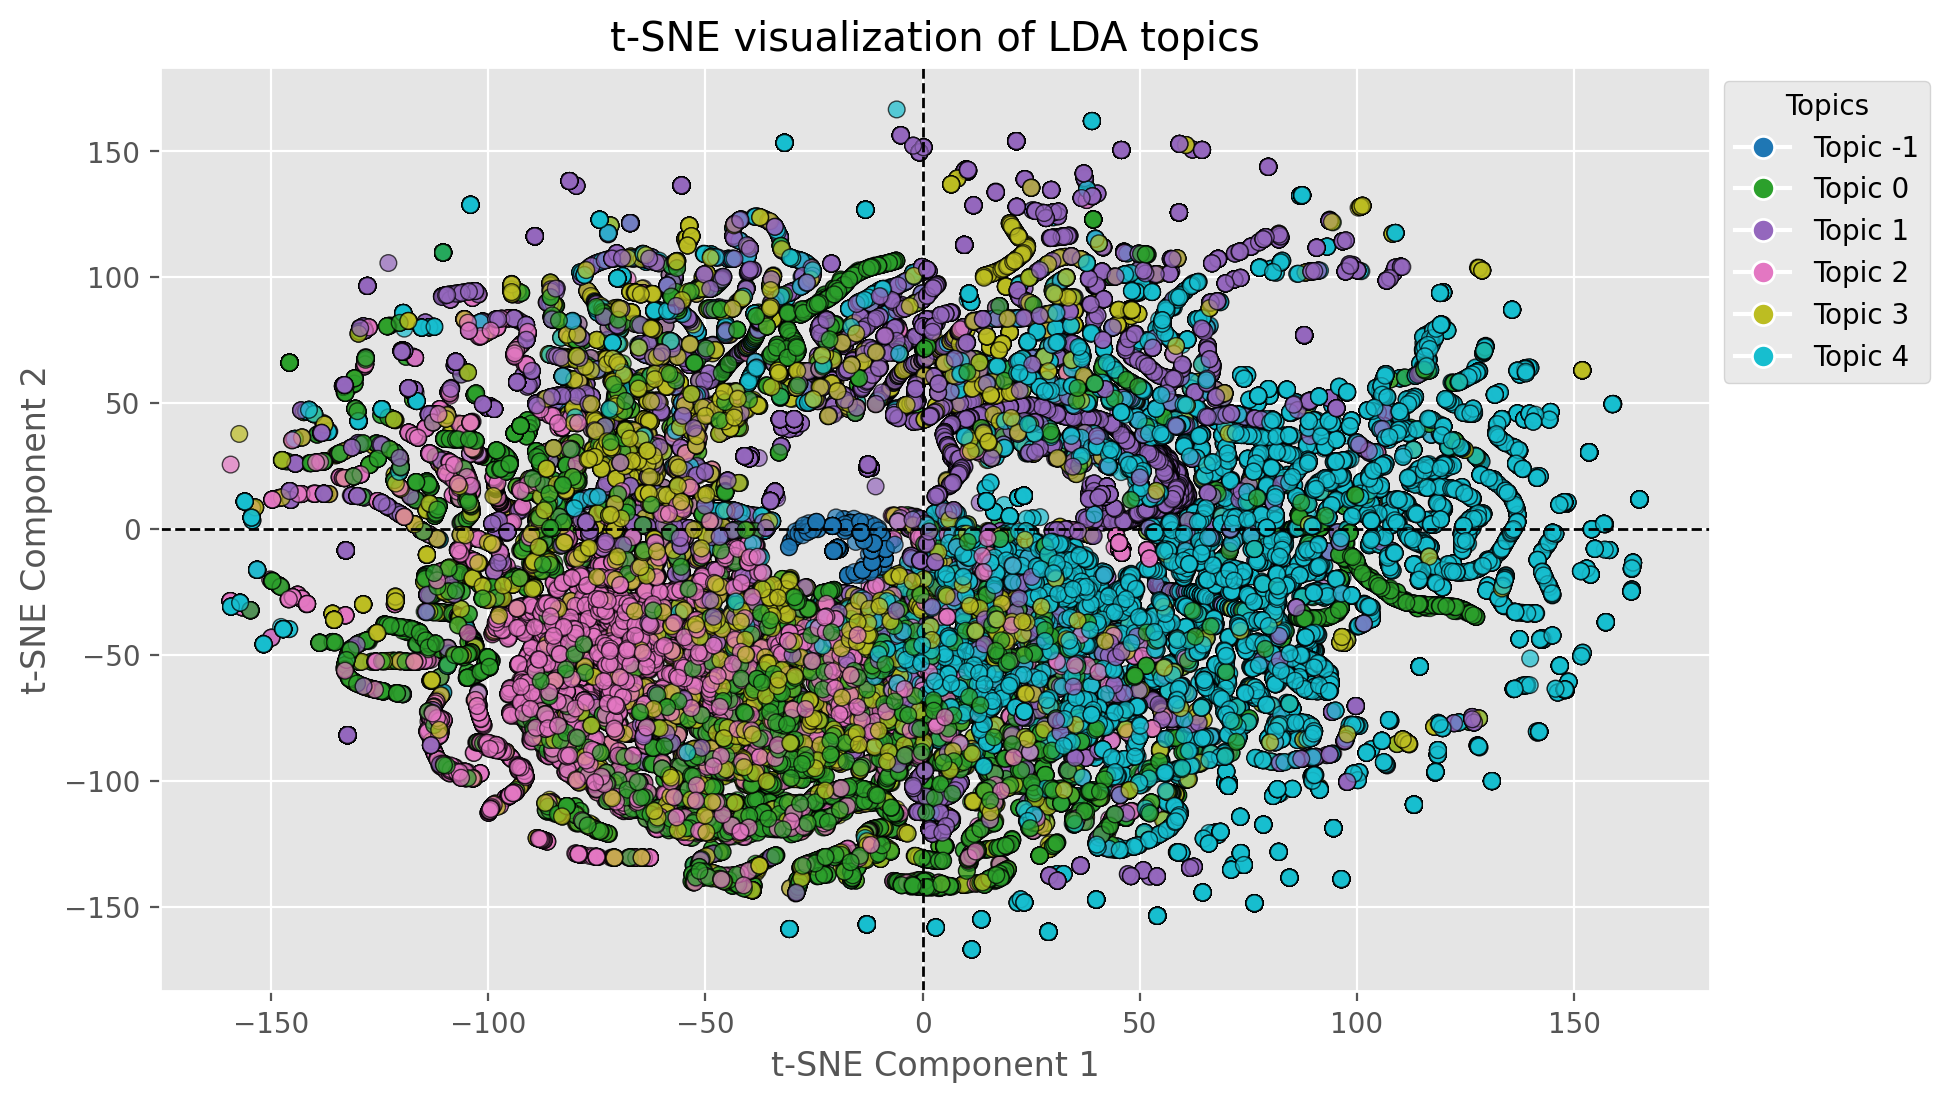

In [90]:
# filter the topic column to match the reduced data
filtered_topics = df4['topic'].iloc[:len(tsne_results)]
# get unique topics and sort them
unique_topics = np.sort(filtered_topics.unique())

# plot t-SNE results
plt.figure(figsize=(10, 6), dpi=200)
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=filtered_topics, 
                      cmap='tab10', alpha=0.7, edgecolor='k')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.axvline(0, color='k', linestyle='--', linewidth=1)

# add legend
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=scatter.cmap(scatter.norm(topic)),
                      markersize=8, label=f'Topic {int(topic)}') for topic in unique_topics]

plt.legend(handles=handles, title="Topics", bbox_to_anchor=(1, 1), loc='upper left')
plt.title('t-SNE visualization of LDA topics')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.show()


**Note**: The plot clearly shows the formation of distinct clusters, suggesting that the topic model effectively groups documents with similar thematic content. The clusters are relatively well-separated, indicating that the topics are reasonably distinct from one another. Some overlap between clusters suggests that there are shared characteristics or similarities among certain topics, which is common in real-world data. There are a few points that appear to be outliers, located outside the main clusters. These might represent documents that do not fit cleanly into any of the defined topics or might be artifacts of the t-SNE algorithm.

In [78]:
display((df4['topic'].value_counts(normalize=True)*100).to_frame().round(2).sort_index().transpose())
display((df4['topic'].value_counts()).to_frame().round(2).sort_index().transpose())

topic        -1      0      1      2      3      4
proportion  2.9  13.75  29.23  11.66  10.13  32.33

topic    -1      0      1      2      3      4
count  3571  16946  36033  14372  12483  39848

In [91]:
# compute coherence score
coherence_model = CoherenceModel(model=tuned_lda_model, texts=df4['tokens'],
                                 dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score:.4f}')

Coherence Score: 0.5616


- The coherence score measures the degree of semantic similarity between high-scoring words in each topic. It ranges from 0 to 1, with higher scores indicating better topic quality. A score of 0.5373 suggests that the topics are moderately coherent. This means that the words in each topic are somewhat related and can collectively convey a clear theme or meaning.
- Perplexity is a measure of how well the probability distribution predicted by the model aligns with the observed data. Lower perplexity indicates a better fit to the data.

In [94]:
# palculate perplexity
perplexity = tuned_lda_model.log_perplexity(corpus)

# convert log perplexity to perplexity
perplexity_value = np.exp(-perplexity)

print(f'Perplexity: {perplexity_value:.4f}')

Perplexity: 1242.3516


#### **4.1.5 Topic Distributions over Time**

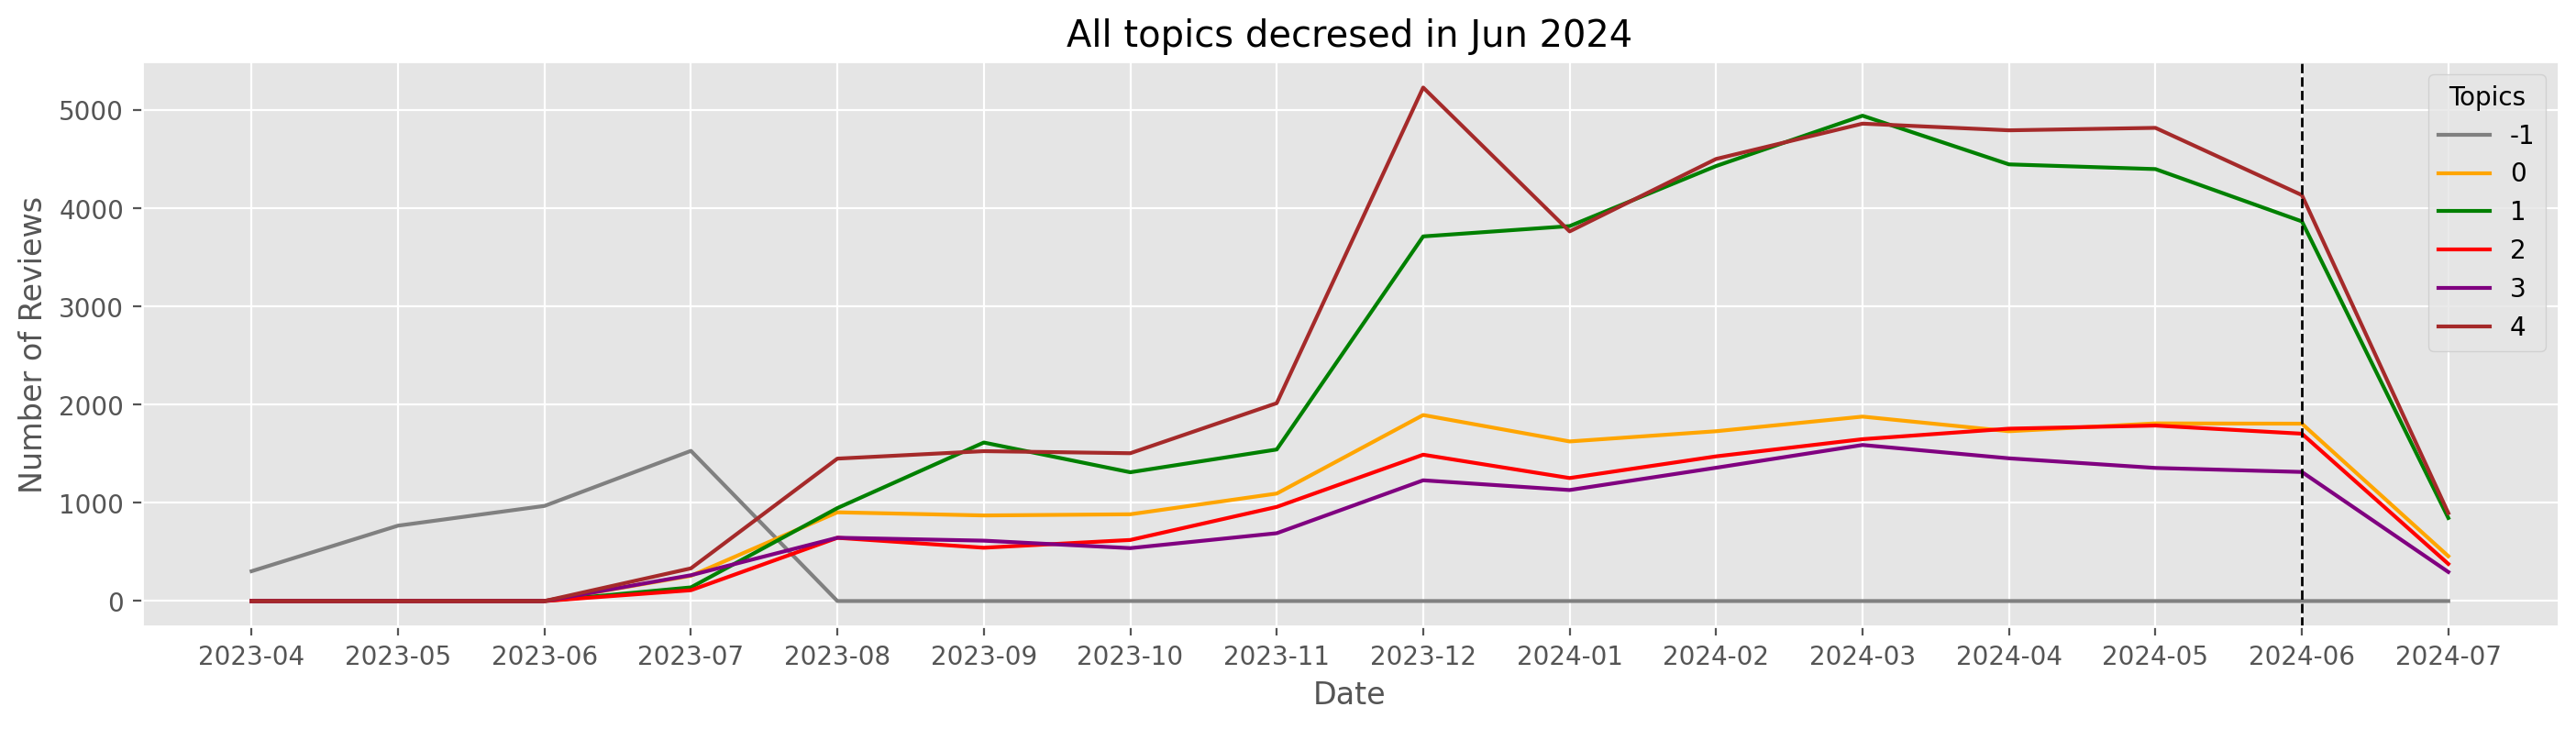

In [97]:
# prepare data
df4['year_month'] = df4['at'].dt.to_period('M').astype(str)
topic_trends = df4.groupby(['year_month', 'topic']).size().unstack(fill_value=0)

# plotting the trends
plt.figure(figsize=(17, 4), dpi=200)
custom_palette = ['grey', 'orange', 'green', 'red', 'purple', 'brown']
line_styles = ['-', '-', '-', '-', '-', '-']
for idx, topic in enumerate(topic_trends.columns):
    sns.lineplot(data=topic_trends[topic],
                 color=custom_palette[idx % len(custom_palette)],
                 linestyle=line_styles[idx % len(line_styles)],
                 label=topic)
# plt.axvline(pd.to_datetime('2024-06-01', format='%Y-%m-%d'), color='k', linestyle='--', linewidth=1)
plt.axvline('2024-06', color='k', linestyle='--', linewidth=1)
plt.title('All topics decresed in Jun 2024')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.legend(title='Topics')
plt.grid(True)
plt.show()

In [98]:
# save model
joblib.dump(tuned_lda_model, '../model/lda_model.pkl')
print('LDA model has been successfully saved!')

LDA model has been successfully saved!


<h1 style='color:orange; text-align:center; font-weight:bold; font-style:italic'>--Move on to Notebook 3--</h1>